In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import time
from statsmodels.stats.weightstats import ztest
from collections import Counter

#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Set Metric

In [2]:
metric = 'EPS'
metric_path = 'data\\processed\\df_quarter_eps_average_08_09.csv'

## Import Data

In [3]:
training_price_path = 'data\\processed\\df_price07_18.csv'
dividend_path = 'data\\processed\\df_monthly_div_07_18.csv'
key_path = 'data\\external\\quarterly_key_sp_500.csv'
testing_price_path = 'data\\processed\\df_price19.csv'
testing_dividend_path = 'data\\processed\\df_quarter_div_19.csv'
recession_dividend_path = 'data\\processed\\df_div_recession.csv'


# main metric import

df = pd.read_csv(metric_path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

# import daily price 07-18

df_price = pd.read_csv(training_price_path)
df_price.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price['Stock'].str.split('_', expand=True)
df_price['symbol'] = new[0]
df_price.index = df_price['symbol']
df_price.drop(['Stock', 'symbol'], axis=1, inplace = True)

# import dividend matrix

df_div = pd.read_csv(dividend_path)
df_div.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div.index = df_div['Stock']
df_div.drop('Stock', axis=1, inplace = True)

# import 2019 price

df_price_19 = pd.read_csv(testing_price_path)
df_price_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price_19['Stock'].str.split('_', expand=True)
df_price_19['symbol'] = new[0]
df_price_19.index = df_price_19['symbol']
df_price_19.drop(['Stock', 'symbol'], axis=1, inplace = True)
df_price_19.sort_index(inplace=True)

# import 2019 dividends
df_div_19 = pd.read_csv(testing_dividend_path)
df_div_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div_19.index = df_div_19['Stock']
df_div_19.drop('Stock', axis=1, inplace = True)

#import recession dividends
df_div_recess = pd.read_csv(recession_dividend_path)
df_div_recess.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div_recess.index = df_div_recess['Stock']
df_div_recess.drop('Stock', axis=1, inplace = True)

## Match Indices

In [4]:
# define indices
idx_price = df_price.index
idx_price19 = df_price_19.index


# drop stocks

idx_price_diff1 = idx_price.difference(idx_price19)
df_price.drop(idx_price_diff1, inplace=True)
print('These stocks are missing from 2019 data: {}'.format(idx_price_diff1))


# define indices

idx_price = df_price.index
idx = df.index
idx_div = df_div.index
idx_div_recess = df_div_recess.index

# drop stocks from metric dataframe

idx_diff1 = idx.difference(idx_price)
df.drop(idx_diff1, inplace=True)
print('df shape: {}'.format(df.shape))


# drop stocks from dividend dataframe

idx_diff2 = idx_div.difference(idx_price)
df_div.drop(idx_diff2, inplace=True)
print('df_div shape: {}'.format(df_div.shape))


# drop stocks from recession dividend dataframe
idx_diff_recess = idx_div_recess.difference(idx_price)
df_div_recess.drop(idx_diff_recess, inplace=True)
print('df_div_recess shape: {}'.format(df_div_recess.shape))

These stocks are missing from 2019 data: Index(['BBT', 'BHI', 'CBS', 'CELG', 'JEC', 'KLAC', 'NEM', 'PIR', 'STI', 'SYMC',
       'VIAB', 'XRX'],
      dtype='object', name='symbol')
df shape: (346, 2)
df_div shape: (346, 108)
df_div_recess shape: (346, 1)


In [5]:
# 2019 indices

idx_price19 = df_price_19.index
idx_div19 = df_div_19.index

idx_diff3 = idx_price19.difference(idx_div19)
df_price_19.drop(idx_diff3, inplace=True)

idx_diff4 = idx_div19.difference(idx_price19)
df_div_19.drop(idx_diff4, inplace=True)

print('df 19 price shape: {}'.format(df_price_19.shape))
print('df 19 div shape: {}'.format(df_div_19.shape))

df 19 price shape: (413, 252)
df 19 div shape: (413, 5)


## Instantiate Key Global Variables

In [6]:
# monthly returns

start_dates = ['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01', '2010-05-03', '2010-06-01', 
              '2010-07-01', '2010-08-02', '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', 
              '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-02', '2011-06-01', 
              '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01', 
              '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02', '2012-05-01', '2012-06-01', 
              '2012-07-02', '2012-08-01', '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
              '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03', 
              '2013-07-01', '2013-08-01', '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02', 
              '2014-01-02', '2014-02-03', '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02', 
              '2014-07-01', '2014-08-01', '2014-09-02', '2013-10-01', '2014-11-03', '2014-12-01', 
              '2015-01-02', '2015-02-02', '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
              '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', 
              '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', 
              '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', 
              '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', 
              '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', 
              '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01', '2018-06-01', 
              '2018-07-02', '2018-08-01', '2018-09-04', '2018-10-01', '2018-11-01', '2018-12-03']

end_dates = ['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-28', '2010-06-30', 
            '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', 
            '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', 
            '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', 
            '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', 
            '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', 
            '2013-01-31', '2013-02-28', '2013-03-28', '2013-04-30', '2013-05-31', '2013-06-28', 
            '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', 
            '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', 
            '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', 
            '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', 
            '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31', 
            '2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30', 
            '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30', 
            '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30', 
            '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', 
            '2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29', 
            '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31']

# function to validate lists above

def list_diff(list1, list2):
    out = [item for item in list1 if not item in list2]
    return out

# validate start dates list

print('Missing Start Dates: {}'.format(list_diff(start_dates, list(df_price.columns))))

# validate end dates list

print('Missing End Dates: {}'.format(list_diff(end_dates, list(df_price.columns))))



# initialize risk free rates for each year
# deannualize 2010-2018 from the start of each year
# keep 2019 as normal

rfr10 = (1+0.0013)**(1/3) - 1
rfr11 = (1+0.0005)**(1/3) - 1
rfr12 = (1+0.0011)**(1/3) - 1
rfr13 = (1+0.00075)**(1/3) - 1
rfr14 = (1+0.0004)**(1/3) - 1
rfr15 = (1+0.0004)**(1/3) - 1
rfr16 = (1+0.0035)**(1/3) - 1
rfr17 = (1+0.0099)**(1/3) - 1
rfr18 = (1+0.0185)**(1/3) - 1

rfr19 = 0.0242
rfr08 = 0.0192

# callable indices

idx_price = df_price.index
idx_div = df_div.index
idx_df = df.index
idx_price_19 = df_price_19.index
idx_div_19 = df_div_19.index

Missing Start Dates: []
Missing End Dates: []


## Build Candidate Pool

In [7]:
# sort stocks by difference between average and recession eps
# 20% smallest differences become candidate stocks

df_cand = pd.DataFrame()
df_not = pd.DataFrame()

ratio = int(round(len(df.index)*0.2))
df['difference'] = abs(df['Recession '+metric] - df['07-18 '+metric])
df.sort_values(by=['difference'], inplace=True)
df['colors'] = ''

df_cand = df.iloc[0:ratio, :]
df_not = df.iloc[ratio:, :]

df_cand['colors'] = 'red'
df_not['colors'] = 'blue'

df.sort_index(inplace=True)
df_cand.sort_index(inplace=True)
df_not.sort_index(inplace=True)

print('Candidate df shape: {}'.format(df_cand.shape))
print('Not Candidate df shape: {}'.format(df_not.shape))

Candidate df shape: (69, 4)
Not Candidate df shape: (277, 4)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata

## Calculate Returns

In [8]:
# returns function for 2010-2018 data

def create_returns(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    
    for start, end in zip(start_dates, end_dates):
        temp_returns[end] = df_price[end] - df_price[start]

    idx_div_diff = idx_div.difference(dataframe.index)
    temp_div = df_div.drop(idx_div_diff) 
    total_returns = temp_returns + temp_div
    percent_returns = pd.DataFrame(index=dataframe.index)
    
    for start, end in zip(start_dates, end_dates):
        percent_returns[end] = total_returns[end]/df_price[start]
    #
    actual_returns = pd.DataFrame(index = dataframe.index, columns = percent_returns.columns)
    
    actual_returns.iloc[:, 0:12] = percent_returns.iloc[:, 0:12] - rfr10
    actual_returns.iloc[:, 12:24] = percent_returns.iloc[:, 12:24] - rfr11
    actual_returns.iloc[:, 24:36] = percent_returns.iloc[:, 24:36] - rfr12
    actual_returns.iloc[:, 36:48] = percent_returns.iloc[:, 36:48] - rfr13
    actual_returns.iloc[:, 48:60] = percent_returns.iloc[:, 48:60] - rfr14
    actual_returns.iloc[:, 60:72] = percent_returns.iloc[:, 60:72] - rfr15
    actual_returns.iloc[:, 72:84] = percent_returns.iloc[:, 72:84] - rfr16
    actual_returns.iloc[:, 84:96] = percent_returns.iloc[:, 84:96] - rfr17
    actual_returns.iloc[:, 96:108] = percent_returns.iloc[:, 96:108] - rfr18
    
    actual_returns = actual_returns.astype(float)
    return actual_returns


# create 2019 returns

def create_returns_19(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    temp_returns = (df_price_19['2019-12-31'] - df_price_19['2019-01-02'] + df_div_19['Annual Dividend Estimate'])/df_price_19['2019-01-02'] - rfr19
    
    idx_temp = temp_returns.index
    idx_frame = dataframe.index
    
    idx_diff_temp = idx_temp.difference(idx_frame)
    temp_returns.drop(idx_diff_temp, inplace=True)
    return temp_returns

#create recession returns

def create_returns_recess(dataframe):
    temp_returns = pd.DataFrame(index=dataframe.index)
    temp_returns = (df_price['2009-06-30'] - df_price['2008-07-01'] + df_div_recess['Recession Dividend'])/df_price['2008-07-01'] - rfr08
    
    idx_temp = temp_returns.index
    idx_frame = dataframe.index
    
    idx_diff_temp = idx_temp.difference(idx_frame)
    temp_returns.drop(idx_diff_temp, inplace=True)
    return temp_returns

In [9]:
df_cand_returns = create_returns(df_cand)
df_not_returns = create_returns(df_not)
df_returns = create_returns(df)

df_returns_19 = create_returns_19(df)
df_returns_recess = create_returns_recess(df)

## Random Sampling

In [10]:
# random sampling functions for building pool of portfolios

def portfolio_training(weights, expected_returns, covariance):
    returns = np.sum(weights*expected_returns)
    risk = np.sqrt(weights.T.dot(covariance).dot(weights))
    sharpe = returns/risk
    return returns, risk, sharpe

def random_portfolios(returns, num_portfolios, size_portfolios):
    start = time.time()
    portfolios = np.zeros((4+size_portfolios, num_portfolios))
    stock_list = []
    for i in range(num_portfolios):
        sample = returns.sample(size_portfolios, random_state=i)
        sample.sort_index(inplace=True)
        idx_list = sample.index.tolist()
        stock_list.append(idx_list)
        expected_returns = sample.mean(axis=1)
        covariance = sample.T.cov()
        cov_inverse = pd.DataFrame(np.linalg.inv(covariance.values), covariance.columns, covariance.index)
        weights = cov_inverse.dot(expected_returns)
        weights /= np.sum(weights)
        
        portfolio_returns, portfolio_risk, portfolio_sharpe = portfolio_training(weights, expected_returns, covariance)
        portfolios[0, i] = portfolio_returns
        portfolios[1, i] = portfolio_risk
        portfolios[2, i] = portfolio_sharpe
        portfolios[3, i] = portfolio_sharpe * np.sqrt(12)
        
        for j in range(len(weights)):
            portfolios[4+j, i] = weights[j]
    
    column_list = ['return', 'risk', 'sharpe', 'proj sharpe', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 
                  'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25']
    port_frame = pd.DataFrame(portfolios.T, columns=column_list)
    end = time.time()
    exe_time = end - start
    print('Approximate time to simulate {0} portfolios: {1} seconds'.format(number, exe_time))
    return port_frame, stock_list

# evaluate portfolios on selected returns data

def evaluate_portfolios(portfolios, stocks, returns):
    start = time.time()
    results = np.zeros((3, number))
    
    for i in range(number):
        weights = portfolios.iloc[i, 4:]
        idx_diff = returns.index.difference(stocks[i])
        port_returns = returns.drop(idx_diff)
        annual_returns = weights.reset_index(drop=True)*port_returns.reset_index(drop=True)
        total_return = annual_returns.sum()
        
        monthly_risk = portfolios.iloc[i, 1]
        annual_risk = monthly_risk*np.sqrt(12)
        
        annual_sharpe = total_return/annual_risk
        
        results[0, i] = total_return
        results[1, i] = annual_risk
        results[2, i] = annual_sharpe
    
    column_list = ['return', 'risk', 'sharpe']
    sim_frame = pd.DataFrame(results.T, columns = column_list)
    
    end = time.time()
    exe_time = end - start
    print('Approximate time to simulate {0} portfolios: {1} seconds'.format(number, exe_time))    
    return sim_frame

### Set portfolio size and number of samples

In [11]:
# build control and alternative portfolio pool
# alternative = recession resistant stocks
# control A = not recession resistant stocks
# control B = all stocks

number = 1000
size = 25

control_1_portfolios, control_1_stocks = random_portfolios(df_not_returns, number, size)
control_2_portfolios, control_2_stocks = random_portfolios(df_returns, number, size)
alternative_portfolios, alternative_stocks = random_portfolios(df_cand_returns, number, size)

Approximate time to simulate 1000 portfolios: 2.7320001125335693 seconds
Approximate time to simulate 1000 portfolios: 2.9749999046325684 seconds
Approximate time to simulate 1000 portfolios: 2.7750000953674316 seconds


### Check if any portfolios are repeated

In [12]:
def compare_stocks(stocks):
    c = Counter(map(tuple, stocks))
    dups = [k for k,v in c.items() if v>1]
    print(dups)

print('control 1 duplicates')
compare_stocks(control_1_stocks)
print('control 2 duplicates')
compare_stocks(control_2_stocks)
print('alternative duplicates')
compare_stocks(alternative_stocks)

control 1 duplicates
[]
control 2 duplicates
[]
alternative duplicates
[]


# Exploring Testing Results

In [13]:
print('2010-2018 Control 1 projected Sharpe mean: {}'.format(control_1_portfolios['proj sharpe'].mean()))
print('2010-2018 Control 2 projected Sharpe mean: {}'.format(control_2_portfolios['proj sharpe'].mean()))
print('2010-2018 Alternative projected Sharpe mean: {}'.format(alternative_portfolios['proj sharpe'].mean()))

2010-2018 Control 1 projected Sharpe mean: 2.2337524719400768
2010-2018 Control 2 projected Sharpe mean: 2.2555738332259225
2010-2018 Alternative projected Sharpe mean: 2.2696031920494733


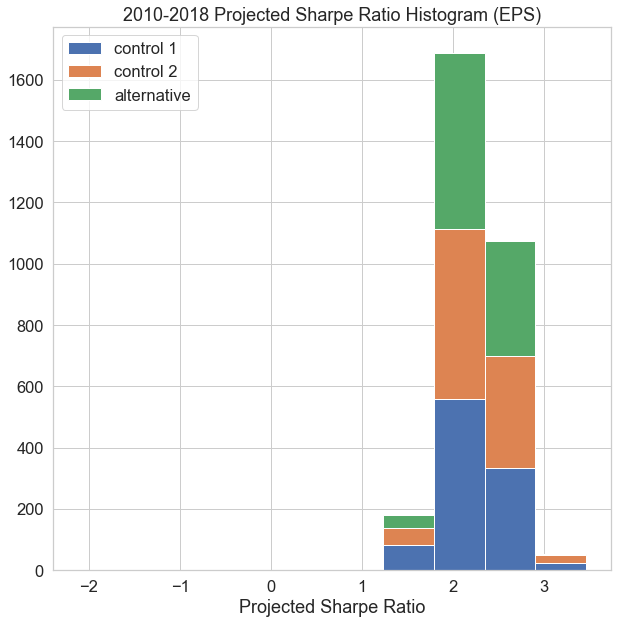

In [14]:
sns.set(style = 'whitegrid', font_scale=1.5)
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[control_1_portfolios['proj sharpe'], control_2_portfolios['proj sharpe'], 
                               alternative_portfolios['proj sharpe']], histtype='barstacked', alpha = 1)

plt.xlabel('Projected Sharpe Ratio')
plt.title('2010-2018 Projected Sharpe Ratio Histogram (' +metric+')')
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, '2010-2018 Projected Sharpe Ratio Boxplots (EPS)')

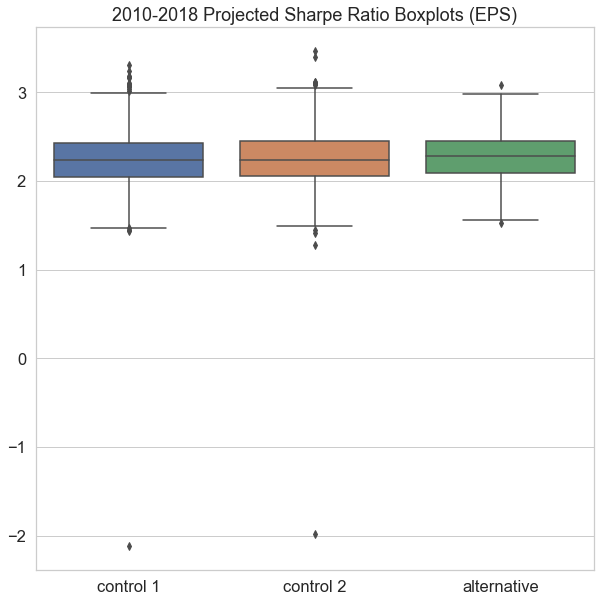

In [15]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=[control_1_portfolios['proj sharpe'], control_2_portfolios['proj sharpe'], 
                       alternative_portfolios['proj sharpe']])
plt.xticks(plt.xticks()[0], ['control 1', 'control 2', 'alternative'])
plt.title('2010-2018 Projected Sharpe Ratio Boxplots (' +metric+')')

# Hypothesis 1: 2019 Data

## Evaluating Results

In [16]:
# evaluate portfolios on 2019 data

control_1_evaluation_19 = evaluate_portfolios(control_1_portfolios, control_1_stocks, df_returns_19)
control_2_evaluation_19 = evaluate_portfolios(control_2_portfolios, control_2_stocks, df_returns_19)
alternative_evaluation_19 = evaluate_portfolios(alternative_portfolios, alternative_stocks, df_returns_19)


# organize data into dataframes

sharpe_data = pd.DataFrame(columns=['control 1', 'control 2', 'alternative'])
sharpe_data['control 1'] = control_1_evaluation_19['sharpe']
sharpe_data['control 2'] = control_2_evaluation_19['sharpe']
sharpe_data['alternative'] = alternative_evaluation_19['sharpe']
sharpe_data.sort_index(inplace=True)

return_data = pd.DataFrame(columns=['control 1', 'control 2', 'alternative'])
return_data['control 1'] = control_1_evaluation_19['return']
return_data['control 2'] = control_2_evaluation_19['return']
return_data['alternative'] = alternative_evaluation_19['return']
return_data.sort_index(inplace=True)

risk_data = pd.DataFrame(columns=['control 1', 'control 2', 'alternative'])
risk_data['control 1'] = control_1_evaluation_19['risk']
risk_data['control 2'] = control_2_evaluation_19['risk']
risk_data['alternative'] = alternative_evaluation_19['risk']
risk_data.sort_index(inplace=True)

Approximate time to simulate 1000 portfolios: 1.2300000190734863 seconds
Approximate time to simulate 1000 portfolios: 1.1140000820159912 seconds
Approximate time to simulate 1000 portfolios: 1.1959998607635498 seconds


In [17]:
# print sharpe stats

print('\n')
print('Control Portfolio 1 2019 Statistics')
print('-'*80)
print('Sharpe mean: {}'.format(sharpe_data['control 1'].mean()))
print('Sharpe std dev: {}'.format(sharpe_data['control 1'].std()))
print('Sharpe std error of mean: {}'.format(sharpe_data['control 1'].std()/np.sqrt(number)))
print('Sharpe range: ({0}, {1})'.format(sharpe_data['control 1'].min(), sharpe_data['control 1'].max()))
print('\n')
print('Returns mean: {}'.format(return_data['control 1'].mean()))
print('Returns std dev: {}'.format(return_data['control 1'].std()))
print('Returns range: ({0}, {1})'.format(return_data['control 1'].min(), return_data['control 1'].max()))
print('\n')
print('Risk mean: {}'.format(risk_data['control 1'].mean()))
print('Risk std dev: {}'.format(risk_data['control 1'].std()))
print('Risk range: ({0}, {1})'.format(risk_data['control 1'].min(), risk_data['control 1'].max()))
print("\n")
print("\n")
print('Control Portfolio 2 2019 Statistics')
print('-'*80)
print('Sharpe mean: {}'.format(sharpe_data['control 2'].mean()))
print('Sharpe std dev: {}'.format(sharpe_data['control 2'].std()))
print('Sharpe std error of mean: {}'.format(sharpe_data['control 2'].std()/np.sqrt(number)))
print('Sharpe range: ({}, {})'.format(sharpe_data['control 2'].min(), sharpe_data['control 2'].max()))
print('\n')
print('Returns mean: {}'.format(return_data['control 2'].mean()))
print('Returns std dev: {}'.format(return_data['control 2'].std()))
print('Returns range: ({0}, {1})'.format(return_data['control 2'].min(), return_data['control 2'].max()))
print('\n')
print('Risk mean: {}'.format(risk_data['control 2'].mean()))
print('Risk std dev: {}'.format(risk_data['control 2'].std()))
print('Risk range: ({0}, {1})'.format(risk_data['control 2'].min(), risk_data['control 2'].max()))
print("\n")
print("\n")
print('Alternative Portfolio 2019 Statistics')
print('-'*80)
print('Sharpe mean: {}'.format(sharpe_data['alternative'].mean()))
print('Sharpe std dev: {}'.format(sharpe_data['alternative'].std()))
print('Sharpe std error of mean: {}'.format(sharpe_data['alternative'].std()/np.sqrt(number)))
print('Sharpe range: ({}, {})'.format(sharpe_data['alternative'].min(), sharpe_data['alternative'].max()))
print('\n')
print('Returns mean: {}'.format(return_data['alternative'].mean()))
print('Returns std dev: {}'.format(return_data['alternative'].std()))
print('Returns range: ({0}, {1})'.format(return_data['alternative'].min(), return_data['alternative'].max()))
print('\n')
print('Risk mean: {}'.format(risk_data['alternative'].mean()))
print('Risk std dev: {}'.format(risk_data['alternative'].std()))
print('Risk range: ({0}, {1})'.format(risk_data['alternative'].min(), risk_data['alternative'].max()))



Control Portfolio 1 2019 Statistics
--------------------------------------------------------------------------------
Sharpe mean: 1.6978051673613024
Sharpe std dev: 1.7775489921427714
Sharpe std error of mean: 0.05621103467707904
Sharpe range: (-4.98286443789208, 7.687493313441815)


Returns mean: 0.3345068434463756
Returns std dev: 0.46554342174722574
Returns range: (-1.9248571825924947, 8.496916608804824)


Risk mean: 0.22485165600223522
Risk std dev: 0.39808911675693887
Risk range: (0.1073354535422898, 12.545022981765465)




Control Portfolio 2 2019 Statistics
--------------------------------------------------------------------------------
Sharpe mean: 1.3884307562852143
Sharpe std dev: 1.7400221353043788
Sharpe std error of mean: 0.05502433126671518
Sharpe range: (-4.011585100614677, 6.888351943458472)


Returns mean: 0.22035175358773218
Returns std dev: 1.0761023859045284
Returns range: (-31.210921099336126, 3.046172558003039)


Risk mean: 0.25810651232974974
Risk std dev: 1.22

## Visualizations

### Sharpe Ratio

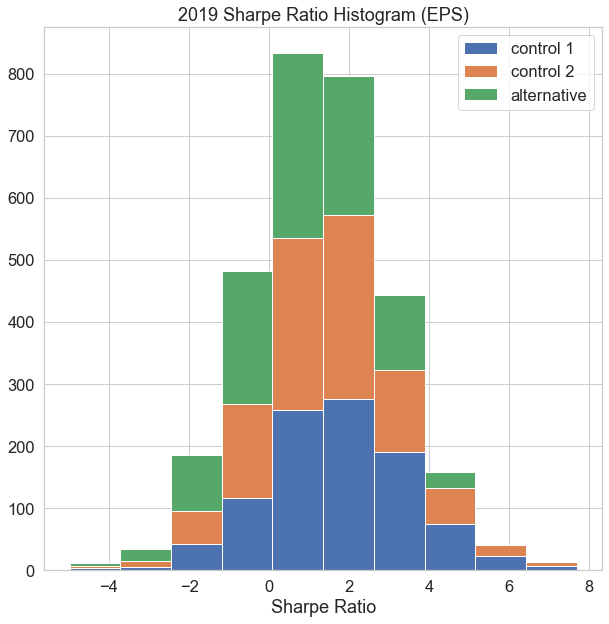

In [18]:
sns.set(style = 'whitegrid', font_scale=1.5)
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[sharpe_data['control 1'], sharpe_data['control 2'], sharpe_data['alternative']],
                            histtype='barstacked', alpha = 1)

plt.xlabel('Sharpe Ratio')
plt.title('2019 Sharpe Ratio Histogram (' +metric+')')
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, '2019 Sharpe Ratio Boxplots (EPS)')

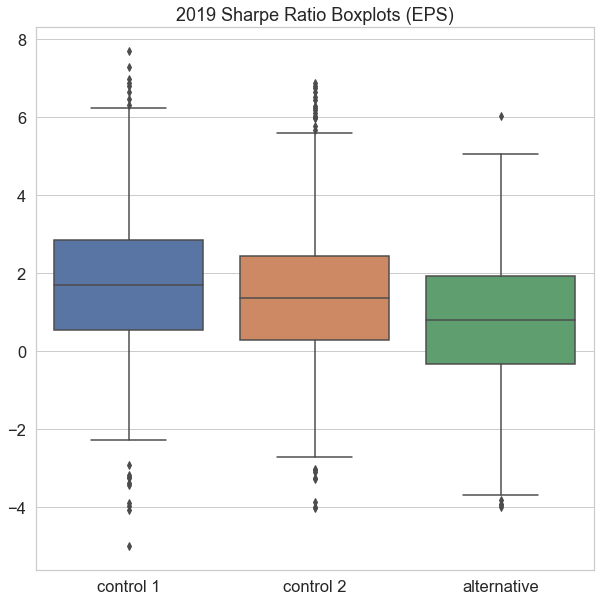

In [19]:
# draw boxplots, QQplot and comment on data

# boxplot looks normally distributed
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=sharpe_data)
plt.title('2019 Sharpe Ratio Boxplots (' +metric+')')

### Returns

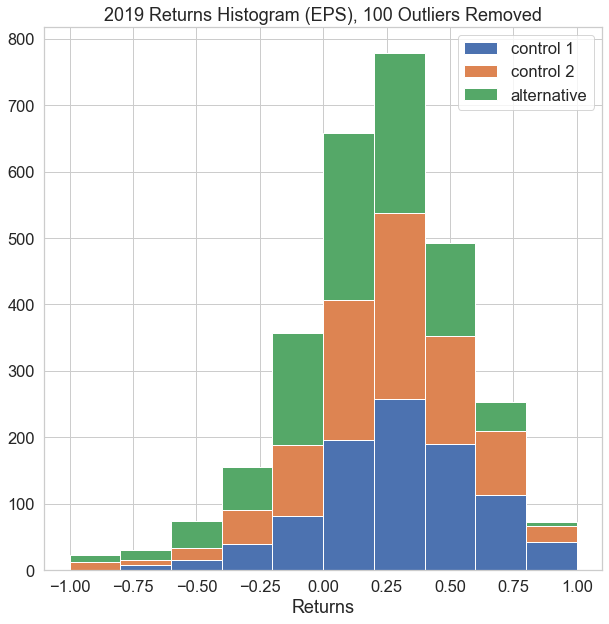

In [20]:
threshold = 1

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[return_data['control 1'], return_data['control 2'], return_data['alternative']],
                            histtype='barstacked', alpha = 1, range = (-1, 1))

hist_return_outlier = return_data[(return_data['alternative'] < threshold) & (return_data['alternative'] >-threshold) 
                             & (return_data['control 2'] < threshold) & (return_data['control 2'] > -threshold) 
                             & (return_data['control 1'] > -threshold)& (return_data['control 1'] < threshold)]

plt.xlabel('Returns')
plt.title('2019 Returns Histogram (' +metric+'), {} Outliers Removed'.format(number - len(hist_return_outlier)))
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, '2019 Returns Boxplots (EPS)')

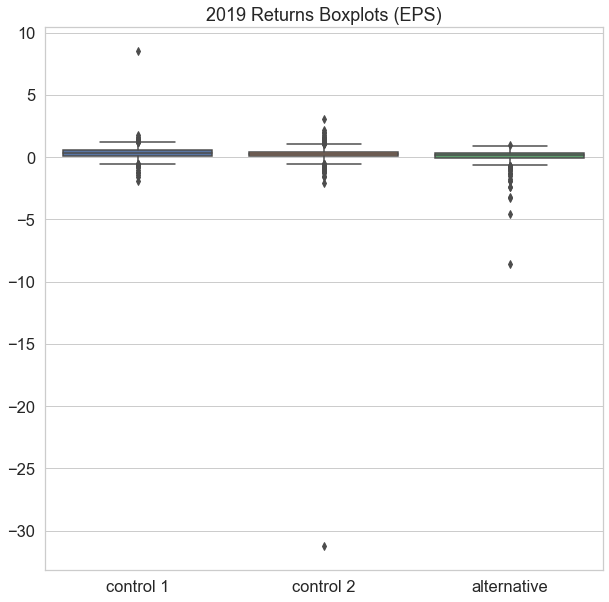

In [21]:
# outliers are skewing the plot

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=return_data)
plt.title('2019 Returns Boxplots (' +metric+')')

number of outliers removed: 999012


Text(0.5, 1.0, '2019 Returns Boxplots (EPS), 12 Outliers Removed')

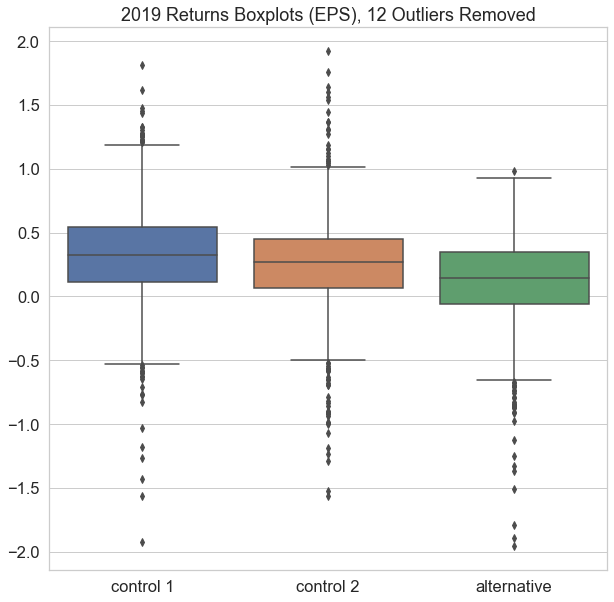

In [22]:
# returns boxplot with outliers greater and less than threshold
threshold = 2
return_outlier = return_data[(return_data['alternative'] < threshold) & (return_data['alternative'] >-threshold) 
                             & (return_data['control 2'] < threshold) & (return_data['control 2'] > -threshold) 
                             & (return_data['control 1'] > -threshold)& (return_data['control 1'] < threshold)]
print('number of outliers removed: {}'.format(1000000 - len(return_outlier)))
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=return_outlier)
plt.title('2019 Returns Boxplots (' +metric+'), {} Outliers Removed'.format(number - len(return_outlier)))

### Risk

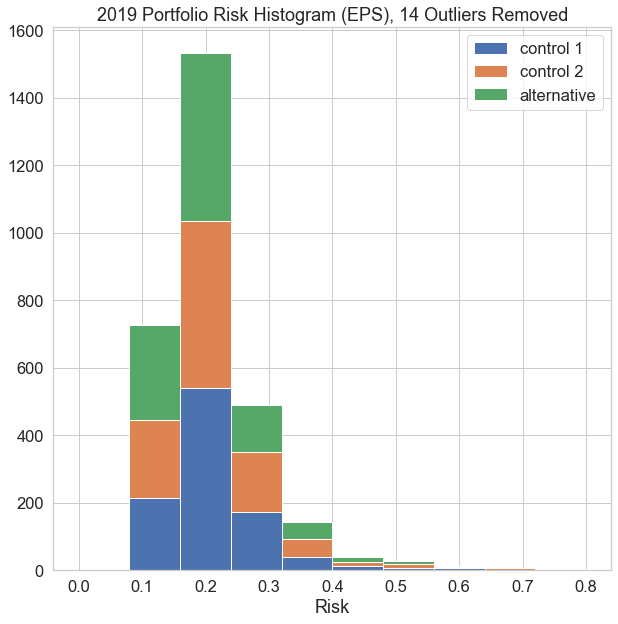

In [23]:
threshold=0.8

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[risk_data['control 1'], risk_data['control 2'], risk_data['alternative']],
                            histtype='barstacked', alpha = 1, range=(0,0.8))

hist_risk_outlier = risk_data[(risk_data['alternative'] < threshold) & (risk_data['alternative'] >-threshold) 
                             & (risk_data['control 2'] < threshold) & (risk_data['control 2'] > -threshold) 
                             & (risk_data['control 1'] > -threshold)& (risk_data['control 1'] < threshold)]

plt.xlabel('Risk')
plt.title('2019 Portfolio Risk Histogram (' +metric+'), {} Outliers Removed'.format(number - len(hist_risk_outlier)))
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, '2019 Risk Boxplots')

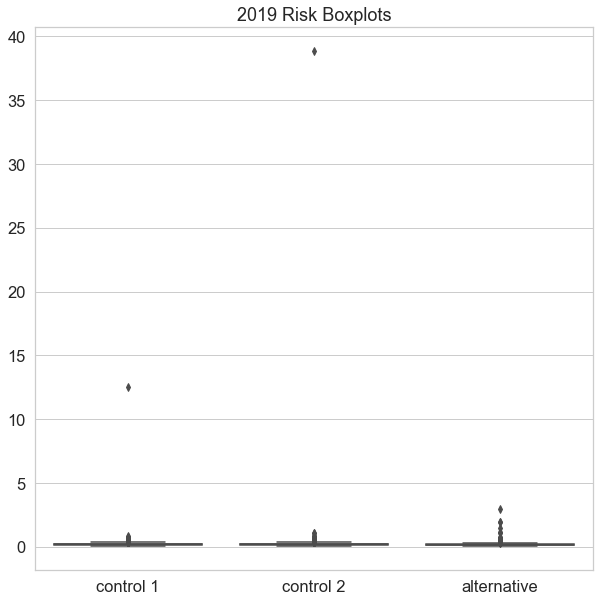

In [24]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=risk_data)
plt.title('2019 Risk Boxplots')

number of outliers removed: 999003


Text(0.5, 1.0, '2019 Risk Boxplots (EPS), 3 Outliers Removed')

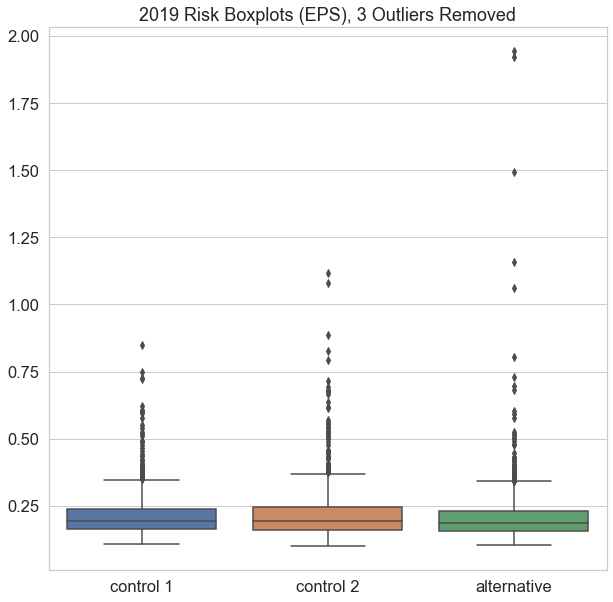

In [25]:
threshold = 2
risk_outlier = risk_data[(risk_data['alternative'] < threshold) & (risk_data['alternative'] >-threshold) 
                             & (risk_data['control 2'] < threshold) & (risk_data['control 2'] > -threshold) 
                             & (risk_data['control 1'] > -threshold)& (risk_data['control 1'] < threshold)]
print('number of outliers removed: {}'.format(1000000 - len(risk_outlier)))
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=risk_outlier)
plt.title('2019 Risk Boxplots (' +metric+'), {} Outliers Removed'.format(number - len(risk_outlier)))

## Statistical Inference: Control 1

In [26]:
# find 95% confidence interval and interpret

def one_sided_confidence_interval(data_con, data_alt):
    data = data_alt-data_con
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * 1.65
    return m-h, float('inf')

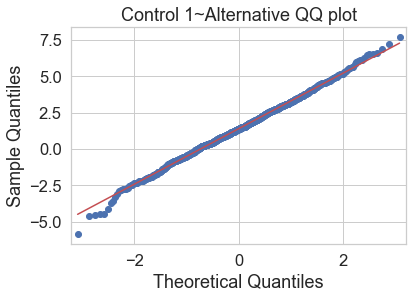

Null Hypothesis: There is no difference between the means of control and alternative sharpe on 2019 data
Alternative Hypothesis: The alternative mean will be greater than control


2 sample z test, alpha=0.05. (Z-score, p-value): (-11.471250512428895, 1.0)


Since p-value is greater than alpha, fail to reject null hypothesis.
95% Confidence Interval: (-1.0097140413218586, inf)


In [27]:
# qq plot
mod_fit = sm.OLS(sharpe_data['control 1'], sharpe_data['alternative']).fit()
res=mod_fit.resid
fig=sm.qqplot(res, line='s')
plt.title('Control 1~Alternative QQ plot')
plt.show()

# test for normality shapiro wilk
# high W score implies normality

#print('normality test for control: {}'.format(stats.shapiro(sharpe_data['control a'])))
#print('normality test for alternative: {}'.format(stats.shapiro(sharpe_data['alternative'])))

# unnecessary since large sample

#stats.levene(sharpe_data['control a'], sharpe_data['alternative'], center='mean')

# 2 sample z test since n > 30
print('Null Hypothesis: There is no difference between the means of control and alternative sharpe on 2019 data')
print('Alternative Hypothesis: The alternative mean will be greater than control')
print('\n')
print('2 sample z test, alpha=0.05. (Z-score, p-value): {}'.format(ztest(sharpe_data['alternative'], x2=sharpe_data['control 1'], alternative='larger')))
print('\n')
print('Since p-value is greater than alpha, fail to reject null hypothesis.')
print('95% Confidence Interval: {}'.format(one_sided_confidence_interval(sharpe_data['control 1'], sharpe_data['alternative'])))

## Statistical Inference: Control 2

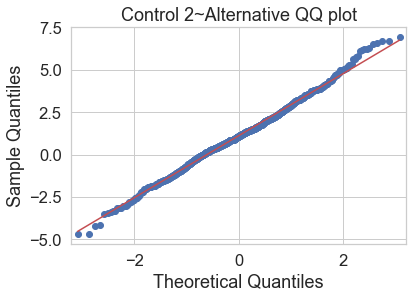

Null Hypothesis: There is no difference between the means of control and alternative sharpe on 2019 data
Alternative Hypothesis: The alternative mean will be greater than control


2 sample z test, alpha=0.05. (Z-score, p-value): (-7.5269884315812625, 0.999999999999974)


Since p-value is greater than alpha, fail to reject null hypothesis.
95% Confidence Interval: (-0.6967127181610159, inf)


In [28]:
# qq plot
mod_fit = sm.OLS(sharpe_data['control 2'], sharpe_data['alternative']).fit()
res=mod_fit.resid
fig=sm.qqplot(res, line='s')
plt.title('Control 2~Alternative QQ plot')
plt.show()

# test for normality shapiro wilk
# high W score implies normality

#print('normality test for control: {}'.format(stats.shapiro(sharpe_data['control b'])))
#print('normality test for alternative: {}'.format(stats.shapiro(sharpe_data['alternative'])))

# unnecessary since large sample

#stats.levene(sharpe_data['control b'], sharpe_data['alternative'], center='mean')

# 2 sample z test since n > 30
print('Null Hypothesis: There is no difference between the means of control and alternative sharpe on 2019 data')
print('Alternative Hypothesis: The alternative mean will be greater than control')
print('\n')
print('2 sample z test, alpha=0.05. (Z-score, p-value): {}'.format(ztest(sharpe_data['alternative'], x2=sharpe_data['control 2'], alternative='larger')))
print('\n')
print('Since p-value is greater than alpha, fail to reject null hypothesis.')
print('95% Confidence Interval: {}'.format(one_sided_confidence_interval(sharpe_data['control 2'], sharpe_data['alternative'])))

# Hypothesis 2: Recession Data

In [29]:
# evaluate portfolios on recession data

control_1_evaluation_recess = evaluate_portfolios(control_1_portfolios, control_1_stocks, df_returns_recess)
control_2_evaluation_recess = evaluate_portfolios(control_2_portfolios, control_2_stocks, df_returns_recess)
alternative_evaluation_recess = evaluate_portfolios(alternative_portfolios, alternative_stocks, df_returns_recess)


# organize data into dataframes

sharpe_data_recess = pd.DataFrame(columns=['control 1', 'control 2', 'alternative'])
sharpe_data_recess['control 1'] = control_1_evaluation_recess['sharpe']
sharpe_data_recess['control 2'] = control_2_evaluation_recess['sharpe']
sharpe_data_recess['alternative'] = alternative_evaluation_recess['sharpe']
sharpe_data_recess.sort_index(inplace=True)

return_data_recess = pd.DataFrame(columns=['control 1', 'control 2', 'alternative'])
return_data_recess['control 1'] = control_1_evaluation_recess['return']
return_data_recess['control 2'] = control_2_evaluation_recess['return']
return_data_recess['alternative'] = alternative_evaluation_recess['return']
return_data_recess.sort_index(inplace=True)

risk_data_recess = pd.DataFrame(columns=['control 1', 'control 2', 'alternative'])
risk_data_recess['control 1'] = control_1_evaluation_recess['risk']
risk_data_recess['control 2'] = control_2_evaluation_recess['risk']
risk_data_recess['alternative'] = alternative_evaluation_recess['risk']
risk_data_recess.sort_index(inplace=True)

Approximate time to simulate 1000 portfolios: 1.1409997940063477 seconds
Approximate time to simulate 1000 portfolios: 1.1800000667572021 seconds
Approximate time to simulate 1000 portfolios: 1.1560001373291016 seconds


In [30]:
# print sharpe stats

print('\n')
print('Control Portfolio 1 2019 Statistics')
print('-'*80)
print('Sharpe mean: {}'.format(sharpe_data_recess['control 1'].mean()))
print('Sharpe std dev: {}'.format(sharpe_data_recess['control 1'].std()))
print('Sharpe std error of mean: {}'.format(sharpe_data_recess['control 1'].std()/np.sqrt(number)))
print('Sharpe range: ({0}, {1})'.format(sharpe_data_recess['control 1'].min(), sharpe_data_recess['control 1'].max()))
print('\n')
print('Returns mean: {}'.format(return_data_recess['control 1'].mean()))
print('Returns std dev: {}'.format(return_data_recess['control 1'].std()))
print('Returns range: ({0}, {1})'.format(return_data_recess['control 1'].min(), return_data_recess['control 1'].max()))
print('\n')
print('Risk mean: {}'.format(risk_data_recess['control 1'].mean()))
print('Risk std dev: {}'.format(risk_data_recess['control 1'].std()))
print('Risk range: ({0}, {1})'.format(risk_data_recess['control 1'].min(), risk_data_recess['control 1'].max()))
print("\n")
print("\n")
print('Control Portfolio 2 2019 Statistics')
print('-'*80)
print('Sharpe mean: {}'.format(sharpe_data_recess['control 2'].mean()))
print('Sharpe std dev: {}'.format(sharpe_data_recess['control 2'].std()))
print('Sharpe std error of mean: {}'.format(sharpe_data_recess['control 2'].std()/np.sqrt(number)))
print('Sharpe range: ({}, {})'.format(sharpe_data_recess['control 2'].min(), sharpe_data_recess['control 2'].max()))
print('\n')
print('Returns mean: {}'.format(return_data_recess['control 2'].mean()))
print('Returns std dev: {}'.format(return_data_recess['control 2'].std()))
print('Returns range: ({0}, {1})'.format(return_data_recess['control 2'].min(), return_data_recess['control 2'].max()))
print('\n')
print('Risk mean: {}'.format(risk_data_recess['control 2'].mean()))
print('Risk std dev: {}'.format(risk_data_recess['control 2'].std()))
print('Risk range: ({0}, {1})'.format(risk_data_recess['control 2'].min(), risk_data_recess['control 2'].max()))
print("\n")
print("\n")
print('Alternative Portfolio 2019 Statistics')
print('-'*80)
print('Sharpe mean: {}'.format(sharpe_data_recess['alternative'].mean()))
print('Sharpe std dev: {}'.format(sharpe_data_recess['alternative'].std()))
print('Sharpe std error of mean: {}'.format(sharpe_data_recess['alternative'].std()/np.sqrt(number)))
print('Sharpe range: ({}, {})'.format(sharpe_data_recess['alternative'].min(), sharpe_data_recess['alternative'].max()))
print('\n')
print('Returns mean: {}'.format(return_data_recess['alternative'].mean()))
print('Returns std dev: {}'.format(return_data_recess['alternative'].std()))
print('Returns range: ({0}, {1})'.format(return_data_recess['alternative'].min(), return_data_recess['alternative'].max()))
print('\n')
print('Risk mean: {}'.format(risk_data_recess['alternative'].mean()))
print('Risk std dev: {}'.format(risk_data_recess['alternative'].std()))
print('Risk range: ({0}, {1})'.format(risk_data_recess['alternative'].min(), risk_data_recess['alternative'].max()))



Control Portfolio 1 2019 Statistics
--------------------------------------------------------------------------------
Sharpe mean: 0.25507428839448415
Sharpe std dev: 1.3056247055632646
Sharpe std error of mean: 0.041287478389666295
Sharpe range: (-3.820197287725704, 4.451171594308321)


Returns mean: 0.06593630320241219
Returns std dev: 0.41963088534593096
Returns range: (-1.2031512447708523, 9.298150761542713)


Risk mean: 0.22485165600223522
Risk std dev: 0.39808911675693887
Risk range: (0.1073354535422898, 12.545022981765465)




Control Portfolio 2 2019 Statistics
--------------------------------------------------------------------------------
Sharpe mean: 0.10244881010462435
Sharpe std dev: 1.2623046191900595
Sharpe std error of mean: 0.039917576975920785
Sharpe range: (-4.2125202385979215, 4.630669768726135)


Returns mean: 0.07625820375201264
Returns std dev: 1.7870454886469722
Returns range: (-1.3263336433995814, 55.77048861860255)


Risk mean: 0.25810651232974974
Risk std de

## Visualizations

### Sharpe Ratio

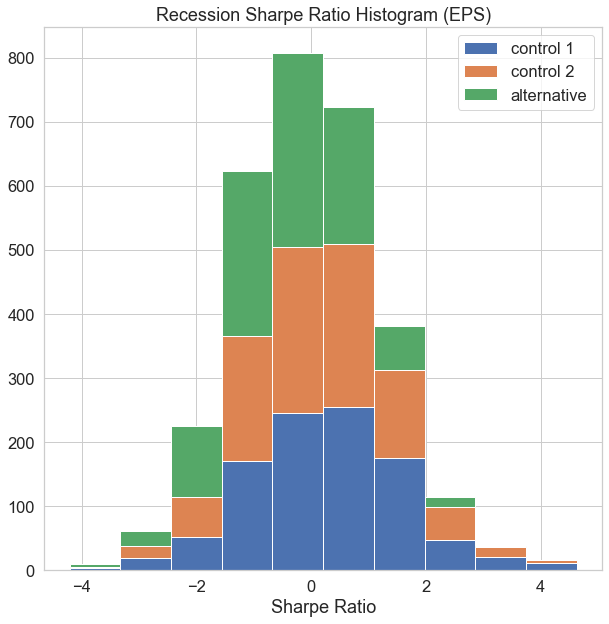

In [31]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[sharpe_data_recess['control 1'], sharpe_data_recess['control 2'], sharpe_data_recess['alternative']],
                            histtype='barstacked', alpha = 1)

plt.xlabel('Sharpe Ratio')
plt.title('Recession Sharpe Ratio Histogram (' +metric+')')
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, 'Recession Sharpe Ratio Boxplots (EPS)')

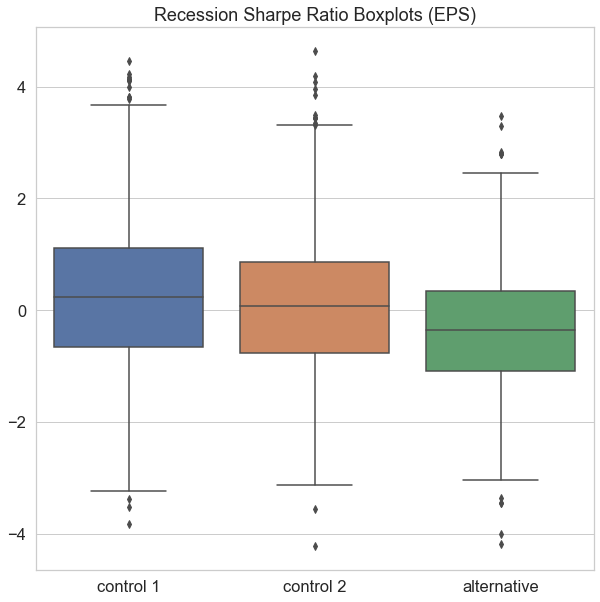

In [32]:
# draw boxplots, QQplot and comment on data

# boxplot looks normally distributed
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=sharpe_data_recess)
plt.title('Recession Sharpe Ratio Boxplots (' +metric+')')

### Returns

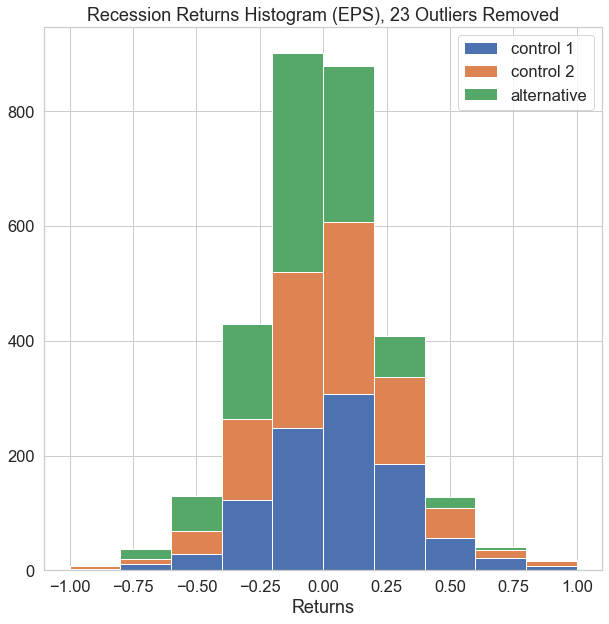

In [33]:
threshold = 1

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[return_data_recess['control 1'], return_data_recess['control 2'], return_data_recess['alternative']],
                            histtype='barstacked', alpha = 1, range = (-1, 1))

hist_return_outlier = return_data_recess[(return_data_recess['alternative'] < threshold) & (return_data_recess['alternative'] >-threshold) 
                             & (return_data_recess['control 2'] < threshold) & (return_data_recess['control 2'] > -threshold) 
                             & (return_data_recess['control 1'] > -threshold)& (return_data_recess['control 1'] < threshold)]

plt.xlabel('Returns')
plt.title('Recession Returns Histogram (' +metric+'), {} Outliers Removed'.format(number - len(hist_return_outlier)))
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, 'Recession Returns Boxplots (EPS)')

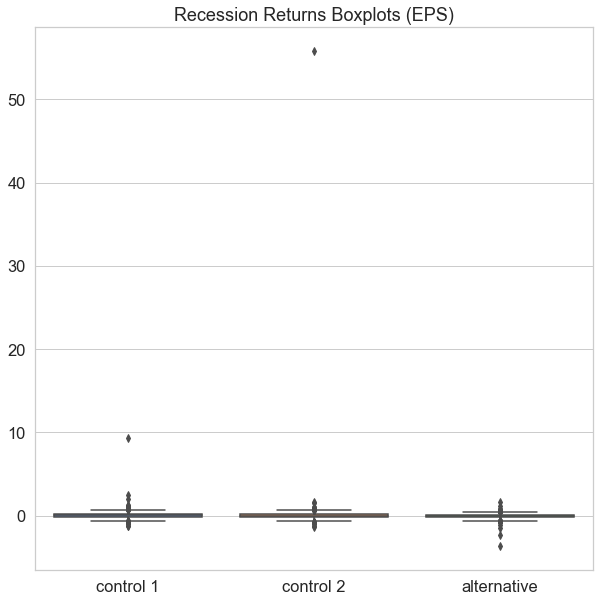

In [34]:
# outliers are skewing the plot

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=return_data_recess)
plt.title('Recession Returns Boxplots (' +metric+')')

Text(0.5, 1.0, 'Recession Returns Boxplots (EPS), 5 Outliers Removed')

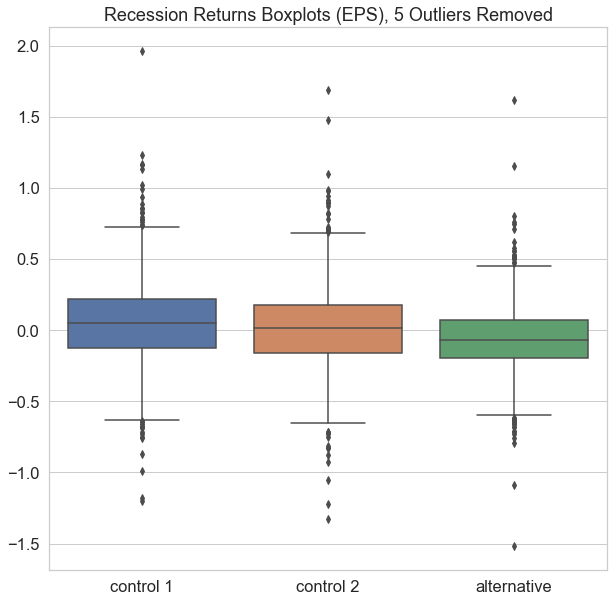

In [35]:
# returns boxplot with outliers greater and less than threshold
threshold = 2
return_outlier = return_data_recess[(return_data_recess['alternative'] < threshold) & (return_data_recess['alternative'] >-threshold) 
                             & (return_data_recess['control 2'] < threshold) & (return_data_recess['control 2'] > -threshold) 
                             & (return_data_recess['control 1'] > -threshold)& (return_data_recess['control 1'] < threshold)]
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=return_outlier)
plt.title('Recession Returns Boxplots (' +metric+'), {} Outliers Removed'.format(number - len(return_outlier)))

### Risk

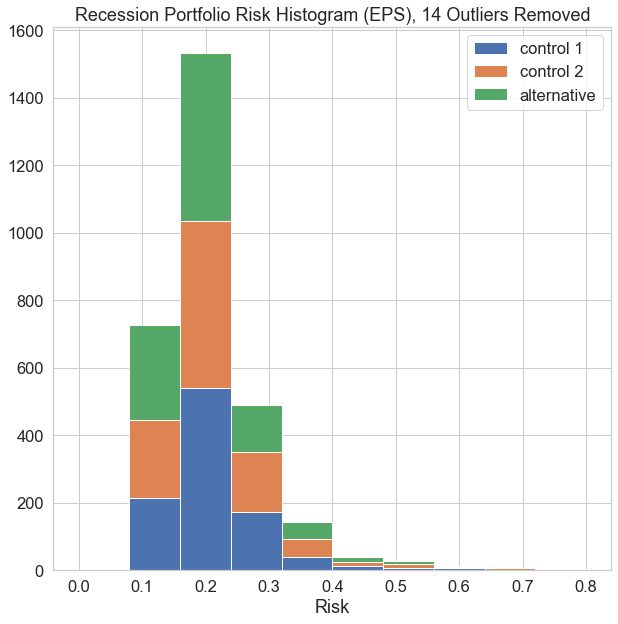

In [36]:
threshold=0.8

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(x=[risk_data_recess['control 1'], risk_data_recess['control 2'], risk_data_recess['alternative']],
                            histtype='barstacked', alpha = 1, range=(0,0.8))

hist_risk_outlier = risk_data_recess[(risk_data_recess['alternative'] < threshold) & (risk_data_recess['alternative'] >-threshold) 
                             & (risk_data_recess['control 2'] < threshold) & (risk_data_recess['control 2'] > -threshold) 
                             & (risk_data_recess['control 1'] > -threshold)& (risk_data_recess['control 1'] < threshold)]

plt.xlabel('Risk')
plt.title('Recession Portfolio Risk Histogram (' +metric+'), {} Outliers Removed'.format(number - len(hist_risk_outlier)))
plt.legend(['control 1', 'control 2', 'alternative'])
plt.show()

Text(0.5, 1.0, 'Recession Risk Boxplots')

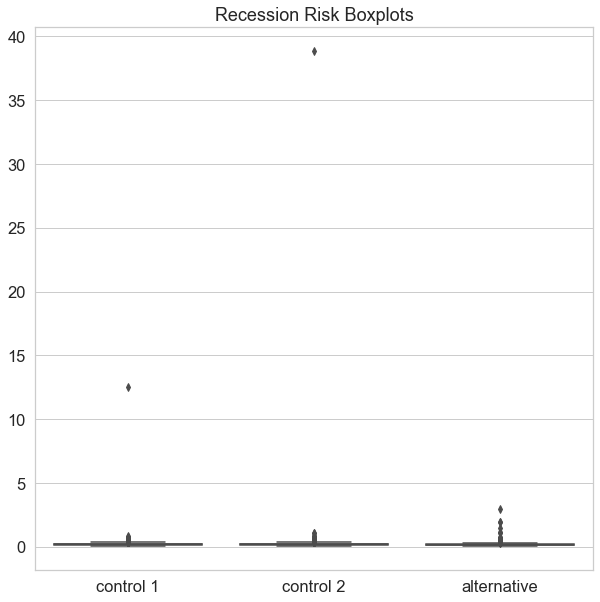

In [37]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=risk_data_recess)
plt.title('Recession Risk Boxplots')

Text(0.5, 1.0, 'Recession Risk Boxplots (EPS), 3 Outliers Removed')

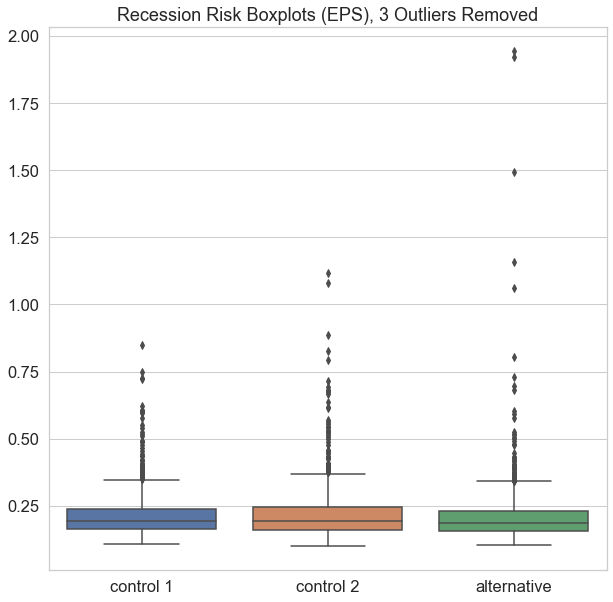

In [38]:
threshold = 2
risk_outlier = risk_data_recess[(risk_data_recess['alternative'] < threshold) & (risk_data_recess['alternative'] >-threshold) 
                             & (risk_data_recess['control 2'] < threshold) & (risk_data_recess['control 2'] > -threshold) 
                             & (risk_data_recess['control 1'] > -threshold)& (risk_data_recess['control 1'] < threshold)]
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=risk_outlier)
plt.title('Recession Risk Boxplots (' +metric+'), {} Outliers Removed'.format(number - len(risk_outlier)))

## Statistical Inference: Control 1

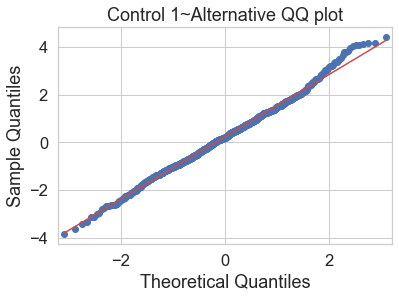

Null Hypothesis: There is no difference between the means of control and alternative sharpe on recession data
Alternative Hypothesis: The alternative mean will be greater than control


2 sample z test, alpha=0.05. (Z-score, p-value): (-11.597006059201458, 1.0)


Since p-value is greater than alpha, fail to reject null hypothesis.
95% Confidence Interval: (-0.7106682634664282, inf)


In [39]:
# qq plot
mod_fit = sm.OLS(sharpe_data_recess['control 1'], sharpe_data_recess['alternative']).fit()
res=mod_fit.resid
fig=sm.qqplot(res, line='s')
plt.title('Control 1~Alternative QQ plot')
plt.show()

# test for normality shapiro wilk
# high W score implies normality

#print('normality test for control: {}'.format(stats.shapiro(sharpe_data_recess['control a'])))
#print('normality test for alternative: {}'.format(stats.shapiro(sharpe_data_recess['alternative'])))

# unnecessary since large sample

#stats.levene(sharpe_data_recess['control a'], sharpe_data_recess['alternative'], center='mean')

# 2 sample z test since n > 30
print('Null Hypothesis: There is no difference between the means of control and alternative sharpe on recession data')
print('Alternative Hypothesis: The alternative mean will be greater than control')
print('\n')
print('2 sample z test, alpha=0.05. (Z-score, p-value): {}'.format(ztest(sharpe_data_recess['alternative'], x2=sharpe_data_recess['control 1'], alternative='larger')))
print('\n')
print('Since p-value is greater than alpha, fail to reject null hypothesis.')
print('95% Confidence Interval: {}'.format(one_sided_confidence_interval(sharpe_data_recess['control 1'], sharpe_data_recess['alternative'])))

## Statistical Inference: Control 2

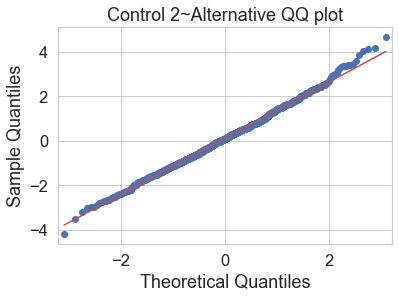

Null Hypothesis: There is no difference between the means of control and alternative sharpe on recession data
Alternative Hypothesis: The alternative mean will be greater than control


2 sample z test, alpha=0.05. (Z-score, p-value): (-8.929122567337393, 1.0)


Since p-value is greater than alpha, fail to reject null hypothesis.
95% Confidence Interval: (-0.5544400166458019, inf)


In [40]:
# qq plot
mod_fit = sm.OLS(sharpe_data_recess['control 2'], sharpe_data_recess['alternative']).fit()
res=mod_fit.resid
fig=sm.qqplot(res, line='s')
plt.title('Control 2~Alternative QQ plot')
plt.show()

# test for normality shapiro wilk
# high W score implies normality

#print('normality test for control: {}'.format(stats.shapiro(sharpe_data_recess['control b'])))
#print('normality test for alternative: {}'.format(stats.shapiro(sharpe_data_recess['alternative'])))

# unnecessary since large sample

#stats.levene(sharpe_data_recess['control b'], sharpe_data_recess['alternative'], center='mean')

# 2 sample z test since n > 30
print('Null Hypothesis: There is no difference between the means of control and alternative sharpe on recession data')
print('Alternative Hypothesis: The alternative mean will be greater than control')
print('\n')
print('2 sample z test, alpha=0.05. (Z-score, p-value): {}'.format(ztest(sharpe_data_recess['alternative'], x2=sharpe_data_recess['control 2'], alternative='larger')))
print('\n')
print('Since p-value is greater than alpha, fail to reject null hypothesis.')
print('95% Confidence Interval: {}'.format(one_sided_confidence_interval(sharpe_data_recess['control 2'], sharpe_data_recess['alternative'])))